In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

from jsm_massfunc import CSMF, SHMR, scatter_stat
from jsm_datareduc import prep_data
import galhalo
import os

In [47]:
Mh = prep_data(("../../data/12_4_0/numpy/acc_surv_mass.npy"), convert=False, includenan=False)
Ms = prep_data(("../../data/12_4_0/numpy/acc_surv_mass.npy"), includenan=False)

In [48]:
Mh = Mh[0:1000] # just to make the matrices smaller
Ms = Ms[0:1000]

In [49]:
def mass_rank(mass):

    rank = np.flip(np.argsort(mass,axis=1), axis=1) # rank the subhalos from largest to smallest

    ranked_mass = np.take_along_axis(mass, rank, axis=1) # this is it!!!

    return rank, ranked_mass
    

### Now working in stellar mass

In [50]:
rank_det, sort_det = mass_rank(Ms)

rank_deth, sort_deth = mass_rank(Mh)

In [51]:
det_ave = np.mean(sort_det, axis=0) #some standard statistics
det_std = np.std(sort_det, axis=0)

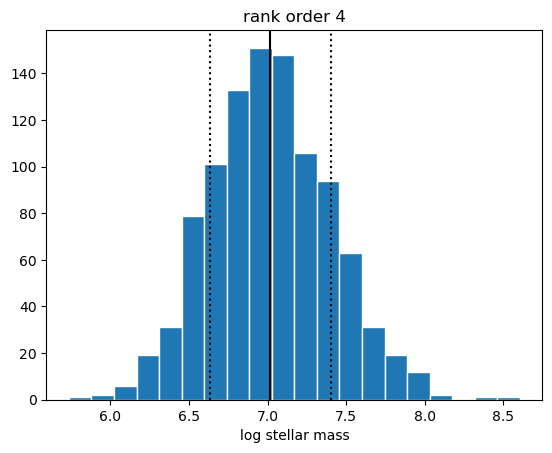

In [52]:
i = 3
plt.title("rank order "+str(i+1))
plt.axvline(det_ave[i], color="black")
plt.axvline(det_ave[i]+det_std[i], ls=":", color="black")
plt.axvline(det_ave[i]-det_std[i], ls=":", color="black")
plt.hist(sort_det[:,i], bins=20, edgecolor="white")
plt.xlabel("log stellar mass")
plt.show()

In [53]:
aves = det_ave[0:20]
stds = det_std[0:20]

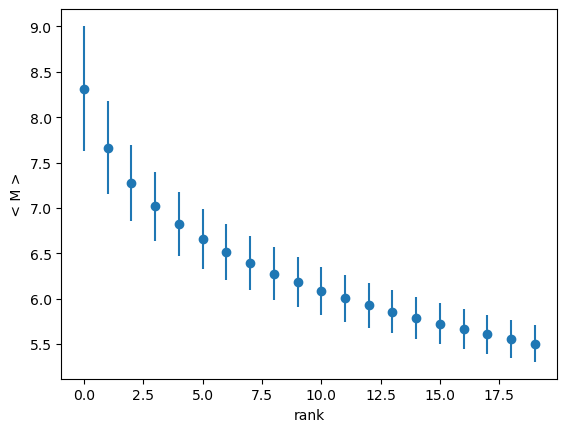

In [54]:
plt.errorbar(range(20), aves, yerr=stds, fmt="o")
plt.xlabel("rank")
plt.ylabel(" < M > ")
plt.show()

### now trying an array of scatter values for several samples

In [55]:
scatter_pix = 15
scatter_range = np.round(np.linspace(0.0,1.5,scatter_pix), 3)
N_samples=500

In [56]:
mat = np.zeros(shape=(scatter_pix, Mh.shape[0], N_samples, Mh.shape[1]))

for i, dex in enumerate(scatter_range):
    mat[i] = galhalo.lgMs_D22_dex(Mh, dex, N_samples, norm=True)

In [57]:
new_mat = np.zeros(shape=(scatter_pix, N_samples, 2, Mh.shape[1]))

for i in range(scatter_pix):
    for j in range(N_samples):
        _, sorted = mass_rank(mat[i,:,j,:])
        ave = np.mean(sorted, axis=0) #some standard statistics
        std = np.std(sorted, axis=0)
        new_mat[i,j] = np.array([ave, std])

In [58]:
binz = np.linspace(6,14,30)

In [59]:
i = 14 # dex
j = 0 # rank
_, ranked_test1 = mass_rank(mat[i,:,100,:])

_, ranked_test2 = mass_rank(mat[i,:,200,:])

_, ranked_test3 = mass_rank(mat[i,:,300,:])


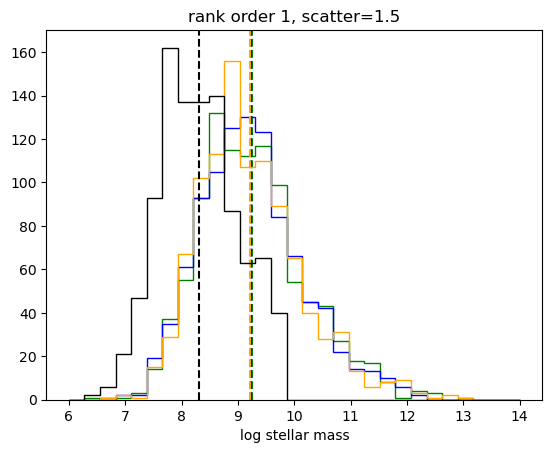

In [60]:
plt.title("rank order "+str(j+1)+", scatter="+str(scatter_range[i]))
plt.hist(ranked_test1[:,j], bins=binz, color="green", histtype=u'step')
plt.axvline(new_mat[i,100,0,j], color="green", ls="--")

plt.hist(ranked_test2[:,j], bins=binz, color="blue", histtype=u'step')
plt.axvline(new_mat[i,200,0,j], color="blue", ls="--")

plt.hist(ranked_test3[:,j], bins=binz, color="orange", histtype=u'step')
plt.axvline(new_mat[i,300,0,j], color="orange", ls="--")

plt.hist(sort_det[:,j], bins=binz, color="black", histtype=u'step')
plt.axvline(det_ave[j], color="black", ls="--")

plt.xlabel("log stellar mass")
plt.show()

In [61]:
across_samp = np.average(new_mat, axis=1) # this averages the averages and the stds!

In [62]:
max_rank = 20
relevant_samp = across_samp[:,:,0:max_rank] # just because we only want the largest

In [63]:
relevant_samp[2,0].shape

(20,)

In [64]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)

colors = mpl.cm.viridis(np.linspace(0, 1, scatter_pix))

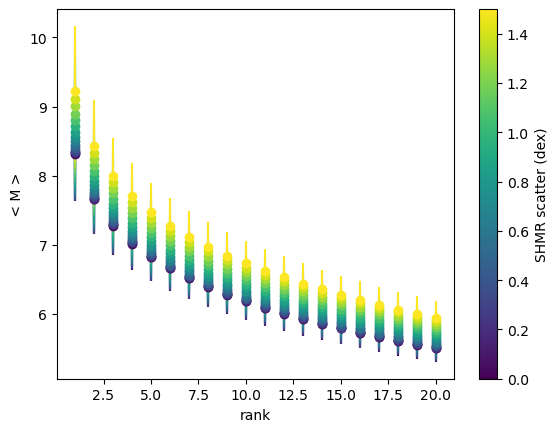

In [65]:
for i in range(scatter_pix):
    plt.errorbar(range(1,max_rank+1), relevant_samp[i,0], yerr=relevant_samp[i,1], fmt="o", color=colors[i])

plt.xlabel("rank")
plt.ylabel(" < M > ")
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.show()

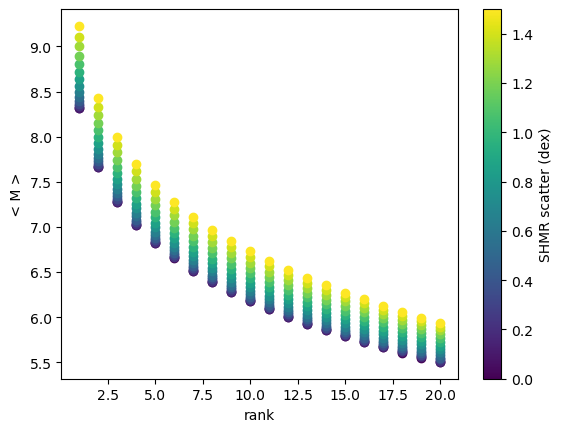

In [66]:
for i in range(scatter_pix):
    plt.scatter(range(1,max_rank+1), relevant_samp[i,0], color=colors[i])

plt.xlabel("rank")
plt.ylabel(" < M > ")
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.show()

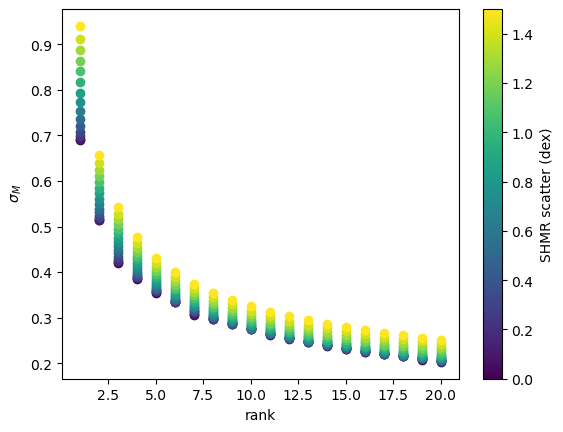

In [67]:
for i in range(scatter_pix):
    plt.scatter(range(1,max_rank+1), relevant_samp[i,1], color=colors[i])

plt.xlabel("rank")
plt.ylabel(" $\sigma_M$ ")
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
ax1.plot(scatter_range, relevant_samp[:,0,0], marker=".", label="Rank 1", color="green")
ax1.axhline(relevant_samp[0,0,0], ls="--", color="green")
ax1.plot(scatter_range, relevant_samp[:,0,4], marker=".", label="Rank 5", color="orange")
ax1.axhline(relevant_samp[0,0,4], ls="--", color="orange")
ax1.plot(scatter_range, relevant_samp[:,0,9], marker=".", label="Rank 10", color="red")
ax1.axhline(relevant_samp[0,0,9], ls="--", color="red")
ax1.set_ylabel(" log M ", fontsize=15)
ax1.set_ylim(6,10)

ax1.legend(loc=2)



ax2.set_xlabel(" $\sigma_{\mathrm{SHMR}}$", fontsize=15)
ax2.plot(scatter_range, relevant_samp[:,1,0], marker=".", label="Rank 1", color="green")
ax2.axhline(relevant_samp[0,1,0], ls="--", color="green")
ax2.plot(scatter_range, relevant_samp[:,1,4], marker=".", label="Rank 5", color="orange")
ax2.axhline(relevant_samp[0,1,4], ls="--", color="orange")
ax2.plot(scatter_range, relevant_samp[:,1,9], marker=".", label="Rank 10", color="red")
ax2.axhline(relevant_samp[0,1,9], ls="--", color="red")
ax2.set_ylabel(" $\sigma_{\mathrm{log M}}$ ", fontsize=15)
ax2.set_ylim(0.25,1)
plt.show()
